# Snake

In [17]:
from helpers import re_normalize_possible_actions
from environments import *
import tensorflow as tf
from datetime import datetime
import numpy as np
from  tqdm import trange
import matplotlib.pyplot as plt

## Environment definition

In [18]:
BOARD_SIZE=3

In [19]:
# region models
input = K.layers.Input(shape=(BOARD_SIZE, BOARD_SIZE, 3))
x = K.layers.Conv2D(64, (3, 3), padding="SAME", activation="linear", use_bias=False)(input)
x = K.layers.BatchNormalization()(x)
x = K.layers.Activation(tf.nn.leaky_relu)(x)

x = K.layers.Conv2D(64, (3, 3), padding="SAME", activation="linear", use_bias=False)(x)
x = K.layers.BatchNormalization()(x)
x = K.layers.Activation(tf.nn.leaky_relu)(x)

x = K.layers.Conv2D(64, (3, 3), padding="SAME", activation="linear", use_bias=False)(x)
x = K.layers.BatchNormalization()(x)
x = K.layers.Activation(tf.nn.leaky_relu)(x)

x = K.layers.MaxPool2D(2)(x)

x = K.layers.Conv2D(64, (2, 2), padding="SAME", activation="linear", use_bias=False)(x)
x = K.layers.BatchNormalization()(x)
x = K.layers.Activation(tf.nn.leaky_relu)(x)

x = K.layers.Conv2D(64, (2, 2), padding="SAME", activation="linear", use_bias=False)(x)
x = K.layers.BatchNormalization()(x)
x = K.layers.Activation(tf.nn.leaky_relu)(x)

x = K.layers.Conv2D(8, (2, 2), padding="SAME", activation="linear", use_bias=False)(x)
x = K.layers.BatchNormalization()(x)
x = K.layers.Activation(tf.nn.leaky_relu)(x)

x = K.layers.GlobalAvgPool2D()(x)

policy = K.layers.Dense(64, activation=tf.nn.leaky_relu)(x)
policy = K.layers.Dense(64, activation=tf.nn.leaky_relu)(policy)
policy = K.layers.Dense(4, activation=tf.nn.softmax)(policy)
agent = K.models.Model(inputs=input, outputs=policy)




input = K.layers.Input(shape=(BOARD_SIZE, BOARD_SIZE, 3))
x = K.layers.Conv2D(64, (3, 3), padding="SAME", activation="linear", use_bias=False)(input)
x = K.layers.BatchNormalization()(x)
x = K.layers.Activation(tf.nn.leaky_relu)(x)

x = K.layers.Conv2D(64, (3, 3), padding="SAME", activation="linear", use_bias=False)(x)
x = K.layers.BatchNormalization()(x)
x = K.layers.Activation(tf.nn.leaky_relu)(x)

x = K.layers.Conv2D(64, (3, 3), padding="SAME", activation="linear", use_bias=False)(x)
x = K.layers.BatchNormalization()(x)
x = K.layers.Activation(tf.nn.leaky_relu)(x)

x = K.layers.MaxPool2D(2)(x)

x = K.layers.Conv2D(64, (2, 2), padding="SAME", activation="linear", use_bias=False)(x)
x = K.layers.BatchNormalization()(x)
x = K.layers.Activation(tf.nn.leaky_relu)(x)

x = K.layers.Conv2D(64, (2, 2), padding="SAME", activation="linear", use_bias=False)(x)
x = K.layers.BatchNormalization()(x)
x = K.layers.Activation(tf.nn.leaky_relu)(x)

x = K.layers.Conv2D(8, (2, 2), padding="SAME", activation="linear", use_bias=False)(x)
x = K.layers.BatchNormalization()(x)
x = K.layers.Activation(tf.nn.leaky_relu)(x)

x = K.layers.GlobalAvgPool2D()(x)

vf = K.layers.Dense(64, activation=tf.nn.leaky_relu)(x)
vf = K.layers.Dense(64, activation=tf.nn.leaky_relu)(vf)
vf = K.layers.Dense(1, activation="linear")(vf)
value = K.models.Model(inputs=input, outputs=vf)

In [20]:
try:
    last_model_trained = sorted([ f.path for f in os.scandir(f'models/{BOARD_SIZE}x{BOARD_SIZE}/') if f.is_dir() ])[-1]
    agent.load_weights(last_model_trained+f"/agent")
    value.load_weights(last_model_trained+f"/value")
except:
    pass

## Training

In [21]:
env_ = NumpyEnvironment(1000, BOARD_SIZE)
env_.FRUIT_REWARD = .5
env_.ATE_HIMSELF_REWARD = .2
env_.WIN_REWARD = 1.
env_.STEP_REWARD = 0.
GAMMA = .99
ITERATIONS = 20000
EPSILON = 0.05

In [22]:
optimizer_value = K.optimizers.Adam(1e-3)
optimizer_agent = K.optimizers.Adam(1e-5)

In [23]:
avg_rewards = []

In [24]:
try :
    import json
    with open(f"model_fitting/trend_{BOARD_SIZE}x{BOARD_SIZE}.txt", "r") as file:
        avg_rewards = json.load(file)
except:
    pass

In [25]:
for iterations in trange(ITERATIONS):
    state = env_.to_state()

    with tf.GradientTape(persistent=True) as tape:
        # calculate distributions of actions
        original_probs = agent(
            state
        )
        # remove actions that are not available
        probs = re_normalize_possible_actions(
            state,
            original_probs + EPSILON
        )
        # sample actions
        actions = tf.random.categorical(tf.math.log(tf.stop_gradient(probs)), 1, dtype=tf.int32)

        # MDP update
        # print("start move")
        rewards = env_.move(actions)
        # print("end move")
        new_state = env_.to_state()

        # TD error
        value_state = value(state)
        td_error = tf.stop_gradient((rewards + GAMMA * value(new_state, training=False)) - value_state) * -1  # to do gradient ascend

        # calculate the loss for both value and agent
        actions_indexes = tf.concat((tf.range(actions.shape[0])[..., None], actions), axis=-1)

        # maybe introduce eligibility trace to simulate n-step td, to have longer dependencies
        loss_agent = tf.stop_gradient(td_error) * tf.math.log(1e-10 + tf.gather_nd(probs, actions_indexes))[...,None]
        loss_value = tf.stop_gradient(td_error) * value_state

        loss_agent = tf.reduce_mean(loss_agent)
        loss_value = tf.reduce_mean(loss_value)

    # calculate gradient
    gradient_agent = tape.gradient(loss_agent, agent.trainable_weights)
    gradient_value = tape.gradient(loss_value, value.trainable_weights)
    avg_rewards.append(tf.reduce_mean(rewards))

    # update neural nets weights
    optimizer_agent.apply_gradients(zip(gradient_agent, agent.trainable_weights))
    optimizer_value.apply_gradients(zip(gradient_value, value.trainable_weights))

    if iterations % 1000 == 0:
        now = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        agent.save_weights(f"models/{BOARD_SIZE}x{BOARD_SIZE}/{now}/agent")
        value.save_weights(f"models/{BOARD_SIZE}x{BOARD_SIZE}/{now}/value")


100%|██████████| 20000/20000 [47:41<00:00,  6.99it/s]


In [26]:
import json
with open(f"model_fitting/trend_{BOARD_SIZE}x{BOARD_SIZE}.txt", "w+") as file:
    json.dump(np.array(avg_rewards).tolist(), file)

### Random policy reward

In [27]:
random_env_ = NumpyEnvironment(1000, BOARD_SIZE)
random_env_.FRUIT_REWARD = .5
random_env_.ATE_HIMSELF_REWARD = .2
random_env_.WIN_REWARD = 1.
random_env_.STEP_REWARD = 0.
GAMMA = .99
ITERATIONS = 10000
EPSILON=0.1
random_rewards = []

for _ in trange(100):
    state = random_env_.to_state()
    probs = re_normalize_possible_actions(
        state,
        tf.repeat([[.25]*4],1000, axis=0)
    )
    #sample actions
    actions =  tf.random.categorical(tf.math.log(probs), 1, dtype=tf.int32)

    # MDP update
    rewards = random_env_.move(actions)
    random_rewards.append(tf.reduce_mean(rewards))

100%|██████████| 100/100 [00:03<00:00, 26.06it/s]


## Training evaluation

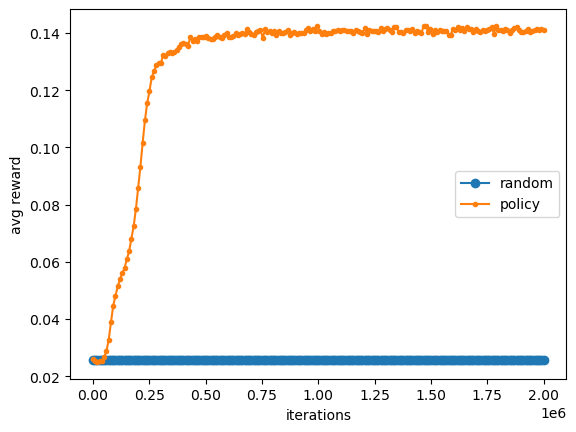

In [28]:
%matplotlib inline

CHUNK_SIZE = 100
N = len(avg_rewards)//CHUNK_SIZE*CHUNK_SIZE
x = np.linspace(0,CHUNK_SIZE*N, N//CHUNK_SIZE)
plt.plot(x, np.array(random_rewards).mean(axis=-1).repeat(N//CHUNK_SIZE), marker="o")
points = np.array(avg_rewards)[:N].reshape((-1, CHUNK_SIZE)).mean(axis=-1)
plt.plot(x, points, marker=".")
_ = plt.xlabel("iterations")
_ = plt.ylabel("avg reward")
plt.legend(["random", "policy"])

## Test (graphical simulation)

In [29]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [30]:
test_env = NumpyEnvironment(2,BOARD_SIZE)

In [31]:
def animate(frame):

    state = test_env.to_state()
    original_probs = agent(
        state
    ) + EPSILON
    probs = re_normalize_possible_actions(
        state,
        original_probs
    )
    actions = tf.argmax(probs, axis=-1)[...,None]
    test_env.move(actions)
    for board, image in zip(test_env.boards, images):
        image.set_data(board)
    return images

In [32]:
fig, axs = plt.subplots(1,2)
images = []
for b, ax in zip(test_env.boards, axs.flatten()):
    images.append(ax.imshow(b, origin="lower"))
anim = FuncAnimation(fig, animate, interval=300)

<IPython.core.display.Javascript object>